## Sentinel2 scenes for East Kimberley field trip

This notebook takes polygons, loads sentinel2 data for the time at which lidar was flown (June 07-19, July 7-11 2017) and saves the output to geotiff.

**Before you run this notebook:** You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

`module use /g/data/v10/public/modules/modulefiles`

`module load dea`

**Date**: September 2018.

**Author**: Claire Krause, Bex Dunn

In [2]:
%matplotlib inline
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube import Datacube
from datetime import datetime
from skimage import exposure
import numpy as np

import sys
import os

###FIXME: this is for getting s2 to write to geotiff
import rasterio

# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append(os.path.abspath('../10_Scripts'))
import DEAPlotting
import DEADataHandling

dc = Datacube(app='Sentinel2')

## See what Sentinel 2 products are currently available

In [3]:
products = dc.list_products()
display_columns = ['name', 'description', 'instrument',
                   'platform', 'product_type', 'crs', 'resolution']
sentinel_products = products[products['instrument'] == 'MSI'][display_columns]
sentinel_products

,name,description,instrument,platform,product_type,crs,resolution
id,,,,,,,
90,s2a_ard_granule,Sentinel-2A MSI ARD - NBAR NBART and Pixel Qua...,MSI,SENTINEL_2A,S2MSIARD,NaN,NaN
92,s2a_level1c_granule,Sentinel-2A Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2A,S2MSI1C,NaN,NaN
91,s2b_ard_granule,Sentinel-2B MSI ARD - NBAR NBART and Pixel Qua...,MSI,SENTINEL_2B,S2MSIARD,NaN,NaN
93,s2b_level1c_granule,Sentinel-2B Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2B,S2MSI1C,NaN,NaN


There are two spectral Sentinel satellites currently in DEA; **Sentinel-2A** and **Sentinel-2B**. Sentinel-2A was launched on 23 June 2015 and Sentinel-2B followed on 7 March 2017.

Both of the Sentinel 2 satellites carries an innovative wide swath high-resolution multispectral imager with 13 spectral bands. The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery. Together they cover all Earth's land surfaces, large islands, inland and coastal waters every five days at the equator.

For more information on the Sentinel 2 platforms and applications, check out the [European Space Agency website](http://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Sentinel-2). 

### query by shapefiles

#### EK_AEM extent shapefile query

In [5]:
shape_file = '/g/data1a/r78/rjd547/groundwater_activities/East_Kimberley/shapefiles/AEM_detailed_extent_Keep_clip.shp'
GEOM, SHAPE_NAME = DEADataHandling.open_polygon_from_shapefile(shape_file)
start_of_epoch, end_of_epoch=('2017-06-01', '2017-07-31')

query = {
    'time': (start_of_epoch, end_of_epoch), 
    'geopolygon': GEOM,
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10)
}

##uncomment this to use lat long instead
# query = {
#         'lat': (-35.25, -35.35),
#         'lon': (149.05, 149.17),
#         'output_crs': 'EPSG:3577',
#         'resolution': (-10, 10),
#         'time': ('2017-01-01', '2017-02-15')
#         }

#### ORD_BON plains investigative area shapefile extent

In [6]:
shape_file_ord = '/g/data1a/r78/rjd547/groundwater_activities/East_Kimberley/shapefiles/Ord_Bonaparte_Plains_investigative_area_shp.shp'
GEOM2, SHAPE_NAME2 = DEADataHandling.open_polygon_from_shapefile(shape_file_ord)

query2 = {
    'time': (start_of_epoch, end_of_epoch), 
    'geopolygon': GEOM2,
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10)
}

##uncomment this to use lat long instead
# query = {
#         'lat': (-35.25, -35.35),
#         'lon': (149.05, 149.17),
#         'output_crs': 'EPSG:3577',
#         'resolution': (-10, 10),
#         'time': ('2017-01-01', '2017-02-15')
#         }

In [7]:
## now load the data

In [8]:
#EK_AEM= dc.load(product='s2a_ard_granule', group_by='solar_day', **query)
ORD_BON= dc.load(product='s2a_ard_granule', group_by='solar_day', **query2)

#### See what came back from the extraction

In [9]:
#EK_AEM 
ORD_BON

<xarray.Dataset>
Dimensions:                (time: 6, x: 5706, y: 4692)
Coordinates:
  * time                   (time) datetime64[ns] 2017-06-07T01:47:01.026000 ...
  * y                      (y) float64 -1.581e+06 -1.581e+06 -1.581e+06 ...
  * x                      (x) float64 -3.817e+05 -3.817e+05 -3.817e+05 ...
Data variables:
    azimuthal_exiting      (time, y, x) float32 -25.075415 -19.834661 ...
    azimuthal_incident     (time, y, x) float32 -152.35944 -144.39355 ...
    exiting                (time, y, x) float32 9.879798 9.761606 9.761606 ...
    incident               (time, y, x) float32 41.659256 42.08572 42.08572 ...
    relative_azimuth       (time, y, x) float32 246.70346 246.70366 ...
    relative_slope         (time, y, x) float32 -127.28402 -124.55889 ...
    satellite_azimuth      (time, y, x) float32 278.91025 278.91025 ...
    satellite_view         (time, y, x) float32 8.667962 8.669349 8.669349 ...
    solar_azimuth          (time, y, x) float32 32.206787 32.20

## About Sentinel 2 bands
Sentinel 2 satellites have 13 spectral channels:

| Sentinel 2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `nbar(t)_coastal_aerosol` | 1 | 443 | 60 | 20 |
| Blue | `nbar(t)_blue` | 2 | 490 | 10 | 65 |
| Green | `nbar(t)_green` | 3 | 560 | 10 | 35 |
| Red | `nbar(t)_red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `nbar(t)_red_edge_1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_3` | 7 | 783 | 20 | 20 |
| NIR | `nbar(t)_nir_1` | 8 | 842 | 10 | 115 |
| Narrow NIR | `nbar(t)_nir_2` | 8A | 865 | 20 | 20 |
| Water vapour | N/A | 9 | 945 | 60 | 20 |
| SWIR - Cirrus | N/A | 10 | 1375 | 60 | 20 |
| SWIR | `nbar(t)_swir_2` | 11 | 1610 | 20 | 90 |
| SWIR | `nbar(t)_swir_3` | 12 | 2190 | 20 | 180 |

These bands cover the visible, near-infrared and short-wave infrared wave lengths.

![Sentinel 2 bands](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)

**Note** There are a number of additional datasets that are alse returned from our query. These are a combination of datasets used in the correction process, and layers relating to pixel quality. We will explore the pixel quality layers below.

## Plot this scene up as true colour image

True colour images approximate what the human eye sees when looking at a landscape. Note that the function used for this true colour plot enhances the contrast between the bands, resulting in a colour-enhanced image.

In [10]:
### set which dataset we are using

In [12]:
ds=ORD_BON
#ds=EK_AEM

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2bc56daa20>)

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


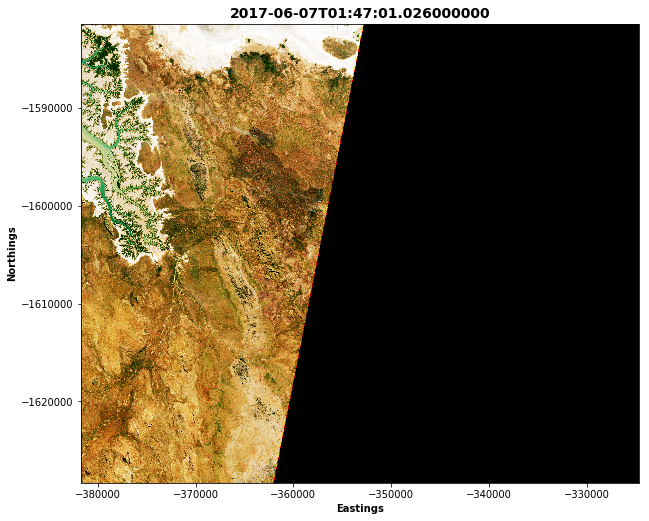

In [14]:
DEAPlotting.three_band_image(ds, bands=['nbar_red', 'nbar_green', 'nbar_blue'],
                             contrast_enhance=True, time=0)

## Plot this scene up as false colour image

This plot uses the SWIR, NIR and green bands to accentuate the presence of water in the landscape.

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2f7e44e128>)

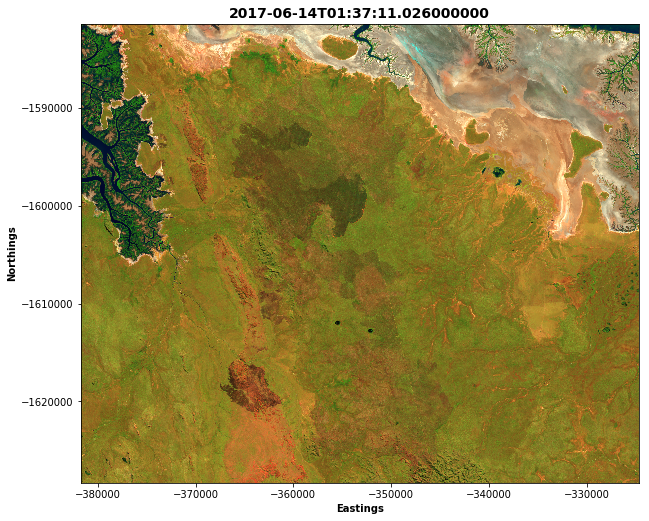

In [15]:
DEAPlotting.three_band_image(
    ds, bands=['nbar_swir_2', 'nbar_nir_1', 'nbar_green'], time=1)

## Compare some scenes side-by-side

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<module 'matplotlib.pyplot' from '/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/matplotlib/pyplot.py'>,
 <Figure size 720x720 with 6 Axes>)

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


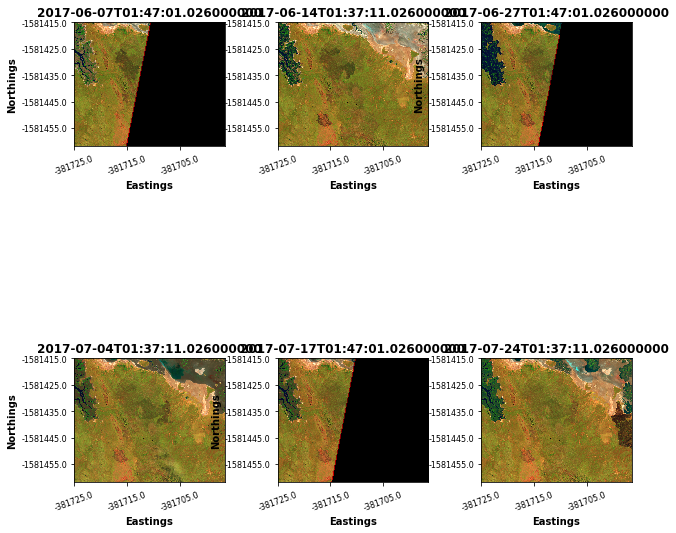

In [16]:
DEAPlotting.three_band_image_subplots(ds, bands=['nbar_swir_2', 'nbar_nir_1', 'nbar_green'],
                                      num_cols=3, figsize=[10, 10], wspace=0.35)

In [20]:
filename=f'/g/data/r78/rjd547/groundwater_activities/East_Kimberley/Sentinel2/OB'

#### this is a really annoying kludge to deal with the fact that new sentinel data has multiple data types and the functions were not written to cope

In [22]:
ds

<xarray.Dataset>
Dimensions:                (time: 6, x: 5706, y: 4692)
Coordinates:
  * time                   (time) datetime64[ns] 2017-06-07T01:47:01.026000 ...
  * y                      (y) float64 -1.581e+06 -1.581e+06 -1.581e+06 ...
  * x                      (x) float64 -3.817e+05 -3.817e+05 -3.817e+05 ...
Data variables:
    nbar_blue              (time, y, x) int16 364 416 526 567 529 529 564 ...
    nbar_green             (time, y, x) int16 559 663 749 789 758 758 761 ...
    nbar_red               (time, y, x) int16 536 692 819 857 884 884 936 ...
    nbar_red_edge_1        (time, y, x) int16 854 975 975 1077 1077 1077 ...
    nbar_red_edge_2        (time, y, x) int16 1636 1246 1246 1135 1135 1135 ...
    nbar_red_edge_3        (time, y, x) int16 1827 1331 1331 1288 1288 1288 ...
    nbar_nir_1             (time, y, x) int16 1925 1444 1155 1042 1106 1106 ...
    nbar_nir_2             (time, y, x) int16 2033 1483 1483 1231 1231 1231 ...
    nbar_swir_2            (time, y,

In [28]:
### here we drop all the bands with other data types. ###FIXME
ds = ds.drop([#'terrain_shadow',
                      #'fmask',
                      #'nbar_contiguity',
                      #'nbart_contiguity',
                     'azimuthal_exiting',
                     'azimuthal_incident',
                     'exiting',
                     'incident',
                     'relative_azimuth',
                     'relative_slope',
                     'satellite_azimuth',
                      'satellite_view',
                      'solar_azimuth',
                      'solar_zenith',
                      'nbar_coastal_aerosol'                      
                     ])

#EK_AEM2.isel(time=i)

ValueError: One or more of the specified variables cannot be found in this dataset

In [30]:
ds

<xarray.Dataset>
Dimensions:                (time: 6, x: 5706, y: 4692)
Coordinates:
  * time                   (time) datetime64[ns] 2017-06-07T01:47:01.026000 ...
  * y                      (y) float64 -1.581e+06 -1.581e+06 -1.581e+06 ...
  * x                      (x) float64 -3.817e+05 -3.817e+05 -3.817e+05 ...
Data variables:
    nbar_blue              (time, y, x) int16 364 416 526 567 529 529 564 ...
    nbar_green             (time, y, x) int16 559 663 749 789 758 758 761 ...
    nbar_red               (time, y, x) int16 536 692 819 857 884 884 936 ...
    nbar_red_edge_1        (time, y, x) int16 854 975 975 1077 1077 1077 ...
    nbar_red_edge_2        (time, y, x) int16 1636 1246 1246 1135 1135 1135 ...
    nbar_red_edge_3        (time, y, x) int16 1827 1331 1331 1288 1288 1288 ...
    nbar_nir_1             (time, y, x) int16 1925 1444 1155 1042 1106 1106 ...
    nbar_nir_2             (time, y, x) int16 2033 1483 1483 1231 1231 1231 ...
    nbar_swir_2            (time, y,

In [23]:
###Note: I munged this to change the datatype for S2
def dataset_to_geotiff2(filename, data):

    """
    this function uses rasterio and numpy to write a multi-band geotiff for one
    timeslice, or for a single composite image. It assumes the input data is an
    xarray dataset (note, dataset not dataarray) and that you have crs and affine
    objects attached, and that you are using float data. future users
    may wish to assert that these assumptions are correct.
    Last modified: March 2018
    Authors: Bex Dunn and Josh Sixsmith
    Modified by: Claire Krause, Robbi Bishop-Taylor
    inputs
    filename - string containing filename to write out to
    data - dataset to write out
    Note: this function currently requires the data have lat/lon only, i.e. no
    time dimension
    """

    # Depreciation warning for write_geotiff
    print("This function will be superceded by the 'write_geotiff' function from 'datacube.helpers'. "
          "Please revise your notebooks to use this function instead")

    kwargs = {'driver': 'GTiff',
              'count': len(data.data_vars),  # geomedian no time dim
              'width': data.sizes['x'], 'height': data.sizes['y'],
              'crs': data.crs.crs_str,
              'transform': data.affine,
              'dtype': list(data.data_vars.values())[0].values.dtype,
              'nodata': 0,
              'compress': 'deflate', 'zlevel': 4, 'predictor': 2}
    # for ints use 2 for floats use 3}

    with rasterio.open(filename, 'w', **kwargs) as src:
        for i, band in enumerate(data.data_vars):
            src.write(data[band].data, i + 1)

### write the list of bands to a textfile

In [24]:
band_list =[]
with open(filename+'band_list_s2.txt','w') as outfile: 
    for i, band in enumerate(ds.data_vars):
        #print(str(f'{i+1} {band} \n'))
        outfile.write(str(f'{i+1} {band} \n'))
        #band_list.append([i+1,band])
    #print(band_list)    

### Write each date to a separate geotiff

In [25]:
print(filename)

/g/data/r78/rjd547/groundwater_activities/East_Kimberley/Sentinel2/OB


In [26]:
#print the dates for which we have imagery and write to file
for i in range(len(ds.time)):
    date_s2 = str(ds.isel(time=i).time.data)[:-19]
    filename2='{}s2_{}.tif'.format(filename,date_s2)
    print(date_s2)
    dataset_to_geotiff2(filename2, ds.isel(time=i))

2017-06-07
This function will be superceded by the 'write_geotiff' function from 'datacube.helpers'. Please revise your notebooks to use this function instead
2017-06-14
This function will be superceded by the 'write_geotiff' function from 'datacube.helpers'. Please revise your notebooks to use this function instead
2017-06-27
This function will be superceded by the 'write_geotiff' function from 'datacube.helpers'. Please revise your notebooks to use this function instead
2017-07-04
This function will be superceded by the 'write_geotiff' function from 'datacube.helpers'. Please revise your notebooks to use this function instead
2017-07-17
This function will be superceded by the 'write_geotiff' function from 'datacube.helpers'. Please revise your notebooks to use this function instead
2017-07-24
This function will be superceded by the 'write_geotiff' function from 'datacube.helpers'. Please revise your notebooks to use this function instead
